In [ ]:
# STEP 9.5 - zoom in topic 0
# Topic Overview Table
# input: topic0_summary_mts30_topic0.csv


import pandas as pd

ts = pd.read_csv("topic0_summary_mts30_topic0.csv")

# Standardize to: topic, name, count (works whether your file has Topic/Name/Count or lowercase)
colmap = {}
for c in ts.columns:
    lc = c.strip().lower()
    if lc == "topic": colmap[c] = "topic"
    if lc == "name":  colmap[c] = "name"
    if lc == "count": colmap[c] = "count"
ts = ts.rename(columns=colmap)

missing = {"topic","name","count"} - set(ts.columns)
if missing:
    raise ValueError(f"Your file is missing expected columns: {missing}. "
                     f"Found columns: {list(ts.columns)}")

# drop the outlier/topic -1 if present
if (-1 in ts["topic"].values):
    ts = ts[ts["topic"] != -1]

# Sort by size
ts = ts.sort_values("count", ascending=False)

# Preview
display(ts[["topic","name","count"]].head(30))



,topic,name,count
1,0,0_hamas_gaza_genocide_palestinians,12710
2,1,1_native_americans_settler_america,649
3,2,2_religion_muslims_muslim_islamic,597
4,3,3_comments_confirm_details_mainstream,503
5,4,4_idf_soldiers_civilians_moral,463
6,5,5_racist_racism_white_black,250
7,6,6_apartheid_south_africa_african,249
8,7,7_wars_started_losing_lost,173
9,8,8_child_kids_kill_women,144
10,9,9_protests_protest_police_germany,138


In [ ]:
#Read a Few Example Posts per Topic
# Save examples for the exact same Top-30 topics used in your bar chart
# (mirrors the same filtering & ordering)

import re
from pathlib import Path
from datetime import datetime
import pandas as pd

# CONFIG (match your viz cell)
TOPIC_SUMMARY_CSV  = "topic0_summary_mts30_topic0.csv"
PER_DOC_CSV        = "topic0_per_doc_mts30_topic0.csv"
MODEL_TAG          = "mts30_topic0"
TOP_N_BARS         = 30
N_PER_TOPIC        = 50   # how many examples per topic
SEED               = 42
DROP_JUNK_TOPICS   = True  # same as viz code

OUT_DIR = Path(f"topic_examples_top{TOP_N_BARS}_{MODEL_TAG}")
OUT_DIR.mkdir(exist_ok=True)

#  Load & standardize
ts = pd.read_csv(TOPIC_SUMMARY_CSV)

def stdcol(df):
    cmap = {}
    for c in df.columns:
        lc = c.strip().lower()
        if lc in {"topic","name","count"}:
            cmap[c] = lc
    out = df.rename(columns=cmap)
    miss = {"topic","name","count"} - set(out.columns)
    if miss:
        raise ValueError(f"Expected topic/name/count in {TOPIC_SUMMARY_CSV}. Missing: {miss}. Found: {list(df.columns)}")
    return out

ts = stdcol(ts)

# drop outlier topic -1 if present
if (-1 in ts["topic"].values):
    ts = ts[ts["topic"] != -1].copy()

# drop junk topics by name (same rule as viz)
if DROP_JUNK_TOPICS:
    junk_pat = re.compile(r"\b(deleted|removed|null|nan)\b", flags=re.IGNORECASE)
    ts = ts[~ts["name"].fillna("").str.contains(junk_pat)].copy()

# order by size and pick Top-N (this is the exact bar chart ordering)
ts = ts.sort_values("count", ascending=False).reset_index(drop=True)
topN = ts.head(TOP_N_BARS).copy()

# Save an index of the selected topics (ranked)
index_path = OUT_DIR / f"top{TOP_N_BARS}_topics_index_{MODEL_TAG}.csv"
idx = topN.assign(rank=range(1, len(topN)+1))[["rank","topic","name","count"]]
idx.to_csv(index_path, index=False)
print(f"✓ wrote topic index → {index_path}")

# Load per-doc assignments and align columns
docs = pd.read_csv(PER_DOC_CSV, low_memory=False)

# unify column names
docs = docs.rename(columns={
    **{c: "topic" for c in docs.columns if c.strip().lower()=="topic"},
    **{c: "text"  for c in docs.columns if c.strip().lower() in {"clean_for_topics","text"}}
})
if "topic" not in docs.columns:
    raise ValueError(f"'topic' column not found in {PER_DOC_CSV}")

# choose best available text column if 'text' still missing
if "text" not in docs.columns:
    for cand in ["clean_for_topics","selftext","body","title"]:
        if cand in docs.columns:
            docs["text"] = docs[cand].astype(str)
            break
    if "text" not in docs.columns:
        raise ValueError(f"No usable text column found in {PER_DOC_CSV}")

# keep only selected topics (same set as bar chart)
keep_ids = set(topN["topic"].tolist())
docs = docs[docs["topic"].isin(keep_ids)].copy()

# build a name map for pretty output
name_map = dict(zip(ts["topic"], ts["name"]))

#  Helper: save per-topic CSV + TXT 
def save_examples_for_topic(tid: int, n: int = 50, seed: int = 42) -> int:
    sub = docs[docs["topic"] == tid].copy()
    if sub.empty:
        print(f"[warn] topic {tid}: 0 docs — skipped.")
        return 0
    n_pick = min(n, len(sub))
    sample = sub.sample(n_pick, random_state=seed).copy()

    # choose columns to export if present
    cols = ["id","subreddit","kind","dt","score","topic","text"]
    # attach auto-name as 'topic_name' for convenience
    sample["topic_name"] = name_map.get(tid, "")
    cols = [c for c in cols if c in sample.columns] + ["topic_name"]
    sample = sample[cols]

    # filename slug
    raw_name = str(name_map.get(tid, f"topic_{tid}"))
    short = re.sub(r"^\d+_", "", raw_name)
    slug = re.sub(r"[^a-z0-9]+", "_", short.lower()).strip("_")[:60]

    csv_path = OUT_DIR / f"topic{tid:03d}_{slug}.csv"
    txt_path = OUT_DIR / f"topic{tid:03d}_{slug}.txt"

    # CSV
    sample.to_csv(csv_path, index=False, encoding="utf-8")

    # TXT (pretty)
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(f"# Topic {tid} — {raw_name}\n")
        f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
        f.write(f"Examples: {n_pick}\n\n")
        for i, row in sample.iterrows():
            header_bits = []
            for k in ["id","subreddit","kind","dt","score"]:
                if k in sample.columns and pd.notna(row.get(k, None)):
                    header_bits.append(f"{k}: {row[k]}")
            header = " | ".join(header_bits) or f"Example {i+1}"
            f.write(f"--- {header} ---\n")
            f.write(str(row["text"]).strip() + "\n\n")

    print(f"✓ topic {tid:3d}: saved {n_pick} → {csv_path.name}, {txt_path.name}")
    return n_pick

#  Save for each topic in bar order (rank order)
total = 0
for tid in topN["topic"].tolist():
    total += save_examples_for_topic(tid, n=N_PER_TOPIC, seed=SEED)

print(f"\n[done] Saved {total} rows across {len(topN)} topics → {OUT_DIR.resolve()}")


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:46: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ts = ts[~ts["name"].fillna("").str.contains(junk_pat)].copy()


✓ wrote topic index → topic_examples_top30_mts30_topic0\top30_topics_index_mts30_topic0.csv


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isof

✓ topic   0: saved 50 → topic000_hamas_gaza_genocide_palestinians.csv, topic000_hamas_gaza_genocide_palestinians.txt
✓ topic   1: saved 50 → topic001_native_americans_settler_america.csv, topic001_native_americans_settler_america.txt
✓ topic   2: saved 50 → topic002_religion_muslims_muslim_islamic.csv, topic002_religion_muslims_muslim_islamic.txt
✓ topic   3: saved 50 → topic003_comments_confirm_details_mainstream.csv, topic003_comments_confirm_details_mainstream.txt


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isof

✓ topic   4: saved 50 → topic004_idf_soldiers_civilians_moral.csv, topic004_idf_soldiers_civilians_moral.txt
✓ topic   5: saved 50 → topic005_racist_racism_white_black.csv, topic005_racist_racism_white_black.txt
✓ topic   6: saved 50 → topic006_apartheid_south_africa_african.csv, topic006_apartheid_south_africa_african.txt
✓ topic   7: saved 50 → topic007_wars_started_losing_lost.csv, topic007_wars_started_losing_lost.txt


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")


✓ topic   8: saved 50 → topic008_child_kids_kill_women.csv, topic008_child_kids_kill_women.txt
✓ topic   9: saved 50 → topic009_protests_protest_police_germany.csv, topic009_protests_protest_police_germany.txt


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isof

✓ topic  10: saved 50 → topic010_jews_white_european_europeans.csv, topic010_jews_white_european_europeans.txt
✓ topic  11: saved 50 → topic011_peaceful_thank_friends_wish.csv, topic011_peaceful_thank_friends_wish.txt
✓ topic  12: saved 50 → topic012_bibi_far_right_extremists_parties.csv, topic012_bibi_far_right_extremists_parties.txt


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isof

✓ topic  13: saved 50 → topic013_cleansing_ethnic_cleansing_ethnic_ethnically.csv, topic013_cleansing_ethnic_cleansing_ethnic_ethnically.txt
✓ topic  14: saved 50 → topic014_egypt_building_hamas_built.csv, topic014_egypt_building_hamas_built.txt
✓ topic  15: saved 50 → topic015_nations_useless_joke_united.csv, topic015_nations_useless_joke_united.txt
✓ topic  16: saved 50 → topic016_soon_conflicts_realize_sadly.csv, topic016_soon_conflicts_realize_sadly.txt


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isof

✓ topic  17: saved 50 → topic017_court_genocide_south_africa.csv, topic017_court_genocide_south_africa.txt
✓ topic  18: saved 50 → topic018_rape_men_prison_video.csv, topic018_rape_men_prison_video.txt
✓ topic  19: saved 50 → topic019_news_journalist_story_reporting.csv, topic019_news_journalist_story_reporting.txt
✓ topic  20: saved 50 → topic020_police_afraid_rate_videos.csv, topic020_police_afraid_rate_videos.txt
✓ topic  21: saved 50 → topic021_nation_jews_national_law.csv, topic021_nation_jews_national_law.txt


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isof

✓ topic  22: saved 50 → topic022_money_america_iran_billion.csv, topic022_money_america_iran_billion.txt
✓ topic  23: saved 50 → topic023_trump_assuming_right_wing_far_right.csv, topic023_trump_assuming_right_wing_far_right.txt
✓ topic  24: saved 50 → topic024_bodies_evidence_story_cut.csv, topic024_bodies_evidence_story_cut.txt


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isof

✓ topic  25: saved 50 → topic025_germany_german_nazis_shit.csv, topic025_germany_german_nazis_shit.txt
✓ topic  26: saved 50 → topic026_oppressed_violent_talk_decade.csv, topic026_oppressed_violent_talk_decade.txt
✓ topic  27: saved 50 → topic027_palestinian_exist_palestinians_arab.csv, topic027_palestinian_exist_palestinians_arab.txt
✓ topic  28: saved 50 → topic028_casualties_count_number_death.csv, topic028_casualties_count_number_death.txt
✓ topic  29: saved 50 → topic029_op_jews_antisemitic_careful.csv, topic029_op_jews_antisemitic_careful.txt

[done] Saved 1500 rows across 30 topics → \\saxolapxxxx\Users\Matilde\Desktop\Thesis_project_2.0_EDIT\topic_examples_top30_mts30_topic0


C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\3347924565.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")


In [ ]:
#top 10 words for each topic

import pandas as pd

TOPIC_SUMMARY_CSV = "topic0_summary_mts30_topic0.csv"  # <-- change if needed
TOP_N = 10
INCLUDE_OUTLIER = False  # set True to include topic -1

# Load & normalize column names
ts = pd.read_csv(TOPIC_SUMMARY_CSV)
ts = ts.rename(columns={"Topic": "topic", "Name": "name", "Count": "count", "Size": "count"})
if "count" not in ts.columns:
    # some exports use lowercase already; nothing to do
    pass

# Drop outlier -1 unless requested
if not INCLUDE_OUTLIER and "topic" in ts.columns:
    ts = ts[ts["topic"] != -1].copy()

# Sort by size (largest first) if available
if "count" in ts.columns:
    ts = ts.sort_values("count", ascending=False)

def parse_words(name: str):
    """Parse BERTopic's 'name' like '3_hamas_israel_gaza...' -> ['hamas','israel','gaza', ...]."""
    if not isinstance(name, str):
        return []
    parts = name.split("_", 1)
    words = parts[1].split("_") if len(parts) > 1 else name.split("_")
    # light clean: drop empties/1-char
    words = [w.strip() for w in words if isinstance(w, str) and w.strip() and len(w.strip()) > 1]
    return words

# Print top-N words for each topic
print("\nTop words per topic (parsed from 'name'):\n")
for _, row in ts.iterrows():
    tid = row.get("topic", "?")
    cnt = row.get("count", None)
    words = parse_words(row.get("name", ""))
    header = f"[Topic {tid}]"
    if pd.notna(cnt):
        header += f" (count={int(cnt):,})"
    print(header)
    print("  " + ", ".join(words[:TOP_N]))
    print()



Top words per topic (parsed from 'name'):

[Topic 0] (count=12,710)
  hamas, gaza, genocide, palestinians

[Topic 1] (count=649)
  native, americans, settler, america

[Topic 2] (count=597)
  religion, muslims, muslim, islamic

[Topic 3] (count=503)
  comments, confirm, details, mainstream

[Topic 4] (count=463)
  idf, soldiers, civilians, moral

[Topic 5] (count=250)
  racist, racism, white, black

[Topic 6] (count=249)
  apartheid, south, africa, african

[Topic 7] (count=173)
  wars, started, losing, lost

[Topic 8] (count=144)
  child, kids, kill, women

[Topic 9] (count=138)
  protests, protest, police, germany

[Topic 10] (count=119)
  jews, white, european, europeans

[Topic 11] (count=117)
  peaceful, thank, friends, wish

[Topic 12] (count=117)
  bibi, far right, extremists, parties

[Topic 13] (count=109)
  cleansing, ethnic cleansing, ethnic, ethnically

[Topic 14] (count=103)
  egypt, building, hamas, built

[Topic 15] (count=103)
  nations, useless, joke, united

[Topic 1

C:\Users\Lenovo Thinkpad\AppData\Local\Temp\ipykernel_20164\1205486671.py:62: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ts = ts[~ts["name"].fillna("").str.contains(junk_pat)].copy()


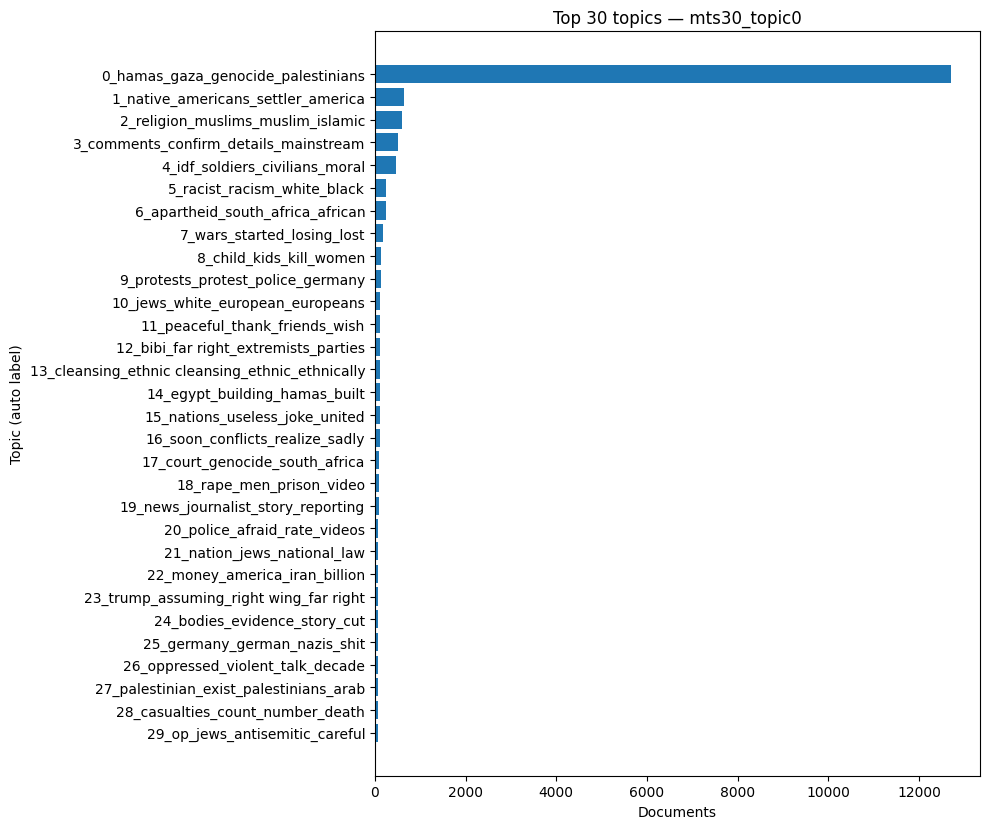

✓ saved bar chart → topic_barchart_top30_mts30_topic0.png


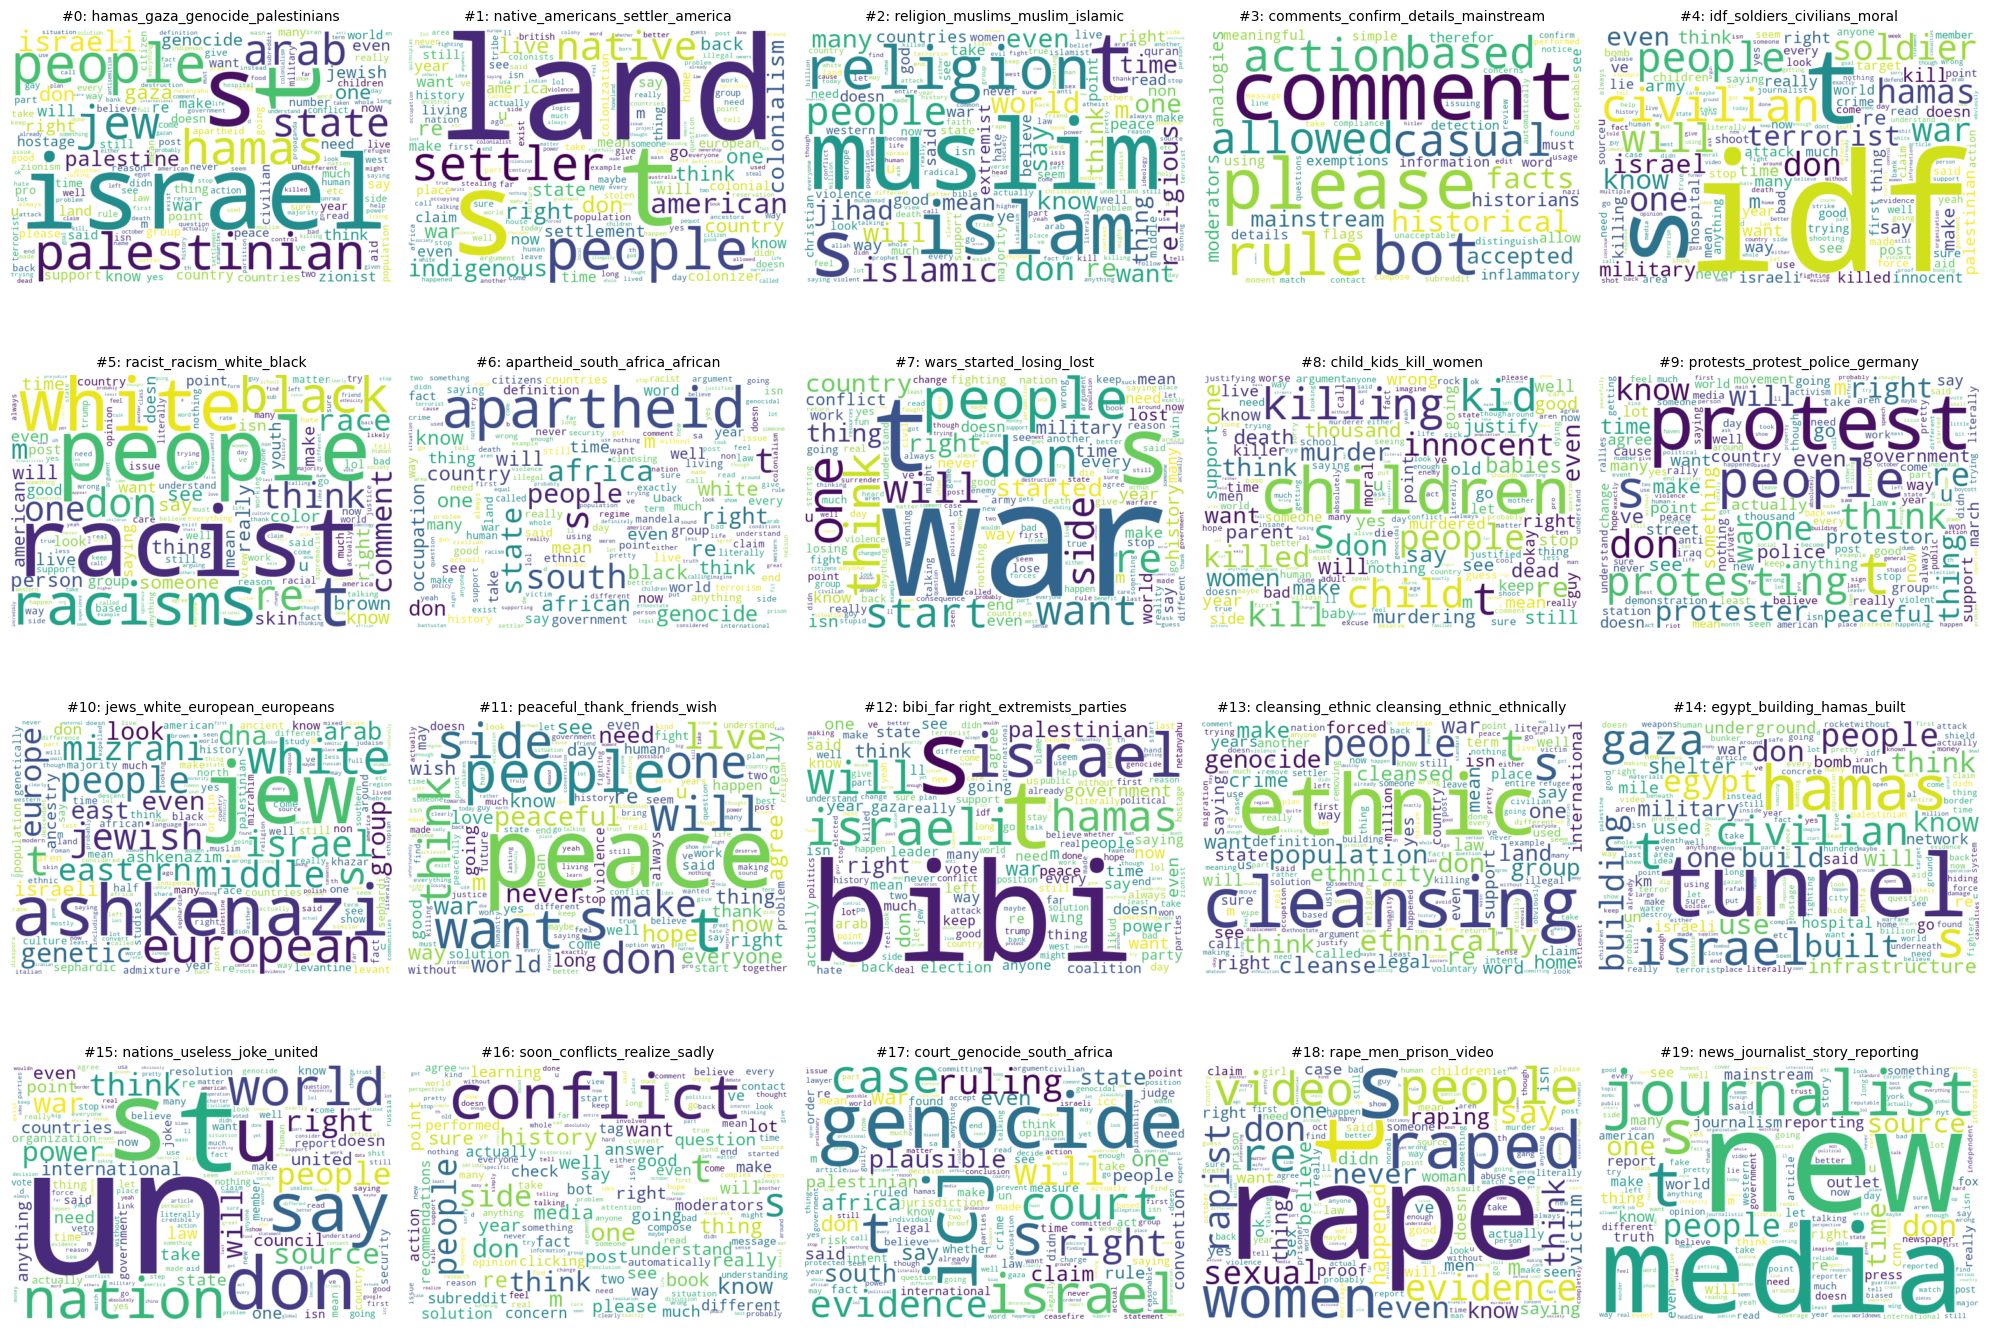

✓ saved wordcloud grid → wordclouds_grid_mts30_topic0.png
✓ saved individual wordclouds → wordclouds_mts30_topic0/


In [ ]:
# --- Visualize BERTopic results for topic 0: bar charts + wordclouds ---
# Inputs:
#   - topic0_summary_mts30_topic0.csv         (topics with counts + names)
#   - topic0_per_doc_mts30_topic0.csv        (each doc with 'topic' + text)
#
# Outputs:
#   - topic_barchart_top30_mts30_topic0.png       (bar chart of largest topics)
#   - wordclouds_grid_mts30_topic0.png            (grid of wordclouds for top topics)
#   - wordclouds_mts30_topic0/<topic>_<slug>.png  (optional: individual wordclouds)



import os, re, math
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  install wordcloud if missing 
try:
    from wordcloud import WordCloud
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

#  CONFIG 
TOPIC_SUMMARY_CSV  = "topic0_summary_mts30_topic0.csv"
PER_DOC_CSV        = "topic0_per_doc_mts30_topic0.csv"
MODEL_TAG          = "mts30_topic0"          # used in file names
TOP_N_BARS         = 30               # bar chart: how many topics
TOP_N_WORDCLOUDS   = 20               # wordcloud grid: how many topics
MAX_DOCS_PER_TOPIC = 400              # sample per topic for wordcloud text
DROP_JUNK_TOPICS   = True             # filter topics named 'deleted/removed/nan...' from visuals
INDIVIDUAL_WC      = True             # also export each wordcloud as its own PNG

#  LOAD & STANDARDIZE COLUMNS 
ts = pd.read_csv(TOPIC_SUMMARY_CSV)
def stdcol(df):
    # rename Topic/Name/Count -> topic/name/count if needed
    cmap = {}
    for c in df.columns:
        lc = c.strip().lower()
        if lc in {"topic", "name", "count"}:
            cmap[c] = lc
    out = df.rename(columns=cmap)
    # sanity
    missing = {"topic","name","count"} - set(out.columns)
    if missing:
        raise ValueError(f"Expected topic/name/count in {TOPIC_SUMMARY_CSV}. Missing: {missing}. Found: {list(df.columns)}")
    return out

ts = stdcol(ts)
# drop outlier cluster if present
if (-1 in ts["topic"].values):
    ts = ts[ts["topic"] != -1]

# optional: drop junky topics by their auto-name
if DROP_JUNK_TOPICS:
    junk_pat = re.compile(r"\b(deleted|removed|null|nan)\b", flags=re.IGNORECASE)
    ts = ts[~ts["name"].fillna("").str.contains(junk_pat)].copy()

ts = ts.sort_values("count", ascending=False).reset_index(drop=True)

docs = pd.read_csv(PER_DOC_CSV, low_memory=False)
# standardize key columns
docs = docs.rename(columns={
    **{c: "topic" for c in docs.columns if c.strip().lower()=="topic"},
    **{c: "text"  for c in docs.columns if c.strip().lower() in {"clean_for_topics","text"}}
})
if "topic" not in docs.columns:
    raise ValueError(f"'topic' column not found in {PER_DOC_CSV}")
if "text" not in docs.columns:
    # fallback to body/selftext/title if available
    for cand in ["body","selftext","title"]:
        if cand in docs.columns:
            docs["text"] = docs[cand].astype(str)
            break
    if "text" not in docs.columns:
        raise ValueError(f"No text column found in {PER_DOC_CSV}")

# keep only topics that remain after filtering
keep_topics = set(ts["topic"].tolist())
docs = docs[docs["topic"].isin(keep_topics)].copy()

#  BAR CHART (Top N topics) 
top_bar = ts.head(TOP_N_BARS).copy()
fig, ax = plt.subplots(figsize=(10, max(6, TOP_N_BARS*0.28)))
ax.barh(top_bar["name"][::-1], top_bar["count"][::-1])
ax.set_xlabel("Documents")
ax.set_ylabel("Topic (auto label)")
ax.set_title(f"Top {TOP_N_BARS} topics — {MODEL_TAG}")
plt.tight_layout()
bar_path = f"topic_barchart_top{TOP_N_BARS}_{MODEL_TAG}.png"
plt.savefig(bar_path, dpi=200)
plt.show()
print(f"✓ saved bar chart → {bar_path}")

#  WORDCLOUDS (Top N topics)
# Build a text blob for each topic from sample docs
def clean_min(t):
    if not isinstance(t, str):
        return ""
    # light clean for WC
    t = t.lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"&amp;", "&", t)
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def gather_text_for_topic(topic_id, n=MAX_DOCS_PER_TOPIC):
    sub = docs[docs["topic"] == topic_id]
    if len(sub) == 0:
        return ""
    # sample to cap runtime/memory
    sub = sub.sample(min(n, len(sub)), random_state=0)
    return " ".join(clean_min(x) for x in sub["text"].astype(str).tolist())

# Create wordclouds for top topics
top_wc = ts.head(TOP_N_WORDCLOUDS).copy()
wc_texts = {}
for _, row in top_wc.iterrows():
    tid, name = int(row["topic"]), str(row["name"])
    wc_texts[tid] = (name, gather_text_for_topic(tid, MAX_DOCS_PER_TOPIC))

# individual exports
out_dir = Path(f"wordclouds_{MODEL_TAG}")
if INDIVIDUAL_WC:
    out_dir.mkdir(parents=True, exist_ok=True)

# grid figure
cols = 5
rows = math.ceil(TOP_N_WORDCLOUDS/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.0, rows*3.6))
axes = np.array(axes).reshape(rows, cols)

for i, (tid, (name, text)) in enumerate(wc_texts.items()):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    if text.strip():
        wc = WordCloud(width=600, height=400, background_color="white", collocations=False).generate(text)
        ax.imshow(wc, interpolation="bilinear")
    else:
        ax.text(0.5, 0.5, "No text", ha="center", va="center", fontsize=12)
        ax.set_facecolor("white")
    ax.axis("off")
    # short label
    short = re.sub(r"^\d+_", "", name)
    short = (short[:50] + "…") if len(short) > 50 else short
    ax.set_title(f"#{tid}: {short}", fontsize=10)
    if INDIVIDUAL_WC and text.strip():
        slug = re.sub(r"[^a-z0-9]+", "_", short.lower()).strip("_")
        wc_path = out_dir / f"topic{tid}_{slug}.png"
        wc.to_file(str(wc_path))

# blank any extra cells
for j in range(len(wc_texts), rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")

plt.tight_layout()
grid_path = f"wordclouds_grid_{MODEL_TAG}.png"
plt.savefig(grid_path, dpi=200)
plt.show()
print(f"✓ saved wordcloud grid → {grid_path}")
if INDIVIDUAL_WC:
    print(f"✓ saved individual wordclouds → {out_dir}/")
